In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [8]:
import tensorflow as tf
import pandas as pd
from pathlib import Path

In [9]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
df = pd.read_csv("CTA_-_Ridership_-_Daily_Boarding_Totals_20250127.csv")

In [11]:
df

,service_date,day_type,bus,rail_boardings,total_rides
0,01/01/2001,U,297192,126455,423647
1,01/02/2001,W,780827,501952,1282779
2,01/03/2001,W,824923,536432,1361355
3,01/04/2001,W,870021,550011,1420032
4,01/05/2001,W,890426,557917,1448343
...,...,...,...,...,...
8792,11/26/2024,W,518470,356826,875296
8793,11/27/2024,W,477247,308919,786166
8794,11/28/2024,U,190991,132382,323373
8795,11/29/2024,W,344005,224635,568640


In [12]:
import pandas as pd
from pathlib import Path

path = Path("CTA_-_Ridership_-_Daily_Boarding_Totals_20250127.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()

In [13]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2024-11-26,W,518470,356826
2024-11-27,W,477247,308919
2024-11-28,U,190991,132382


In [14]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [15]:
# W is weekday
# A for saturday
# U for sunday and holidays

<Axes: xlabel='date'>

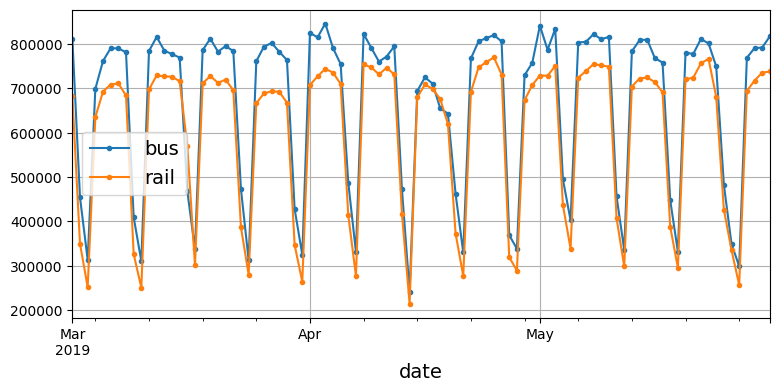

In [16]:
df["2019-03" : "2019-05"].plot(grid=True, marker=".", figsize=(9,4))

In [17]:
df["2019-03" : "2019-05"]

,day_type,bus,rail
date,,,
2019-03-01,W,812238,682969
2019-03-02,A,454119,349392
2019-03-03,U,313539,252150
2019-03-04,W,699086,635353
2019-03-05,W,761781,692945
...,...,...,...
2019-05-27,U,298987,256757
2019-05-28,W,769069,694292
2019-05-29,W,791059,717681


In [18]:
df["2019-03" : "2019-05"].sum()

,0
day_type,WAUWWWWWAUWWWWWAUWWWWWAUWWWWWAUWWWWWAUWWWWWAUW...
bus,61348895
rail,55611788


In [19]:
# shifted to the right

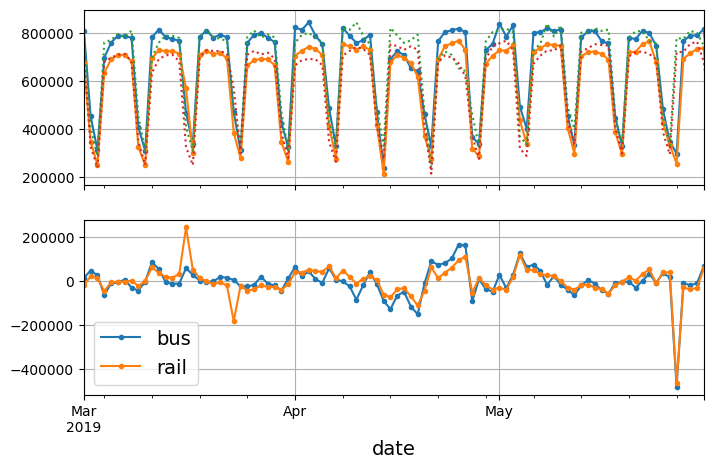

In [20]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])
plt.show()

In [21]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [22]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


In [23]:
target = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7/target).abs().mean() # mean absolute percentage error

,0
bus,0.082938
rail,0.089948


In [24]:
# 8.3% for bus
# 9.0% for rail

In [25]:
# Checking for yearly seasonality

numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]
df_monthly = df_numeric.resample('M').mean()
period = slice("2001", "2019")

<ipython-input-25-1ddee20706a3>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_numeric.resample('M').mean()


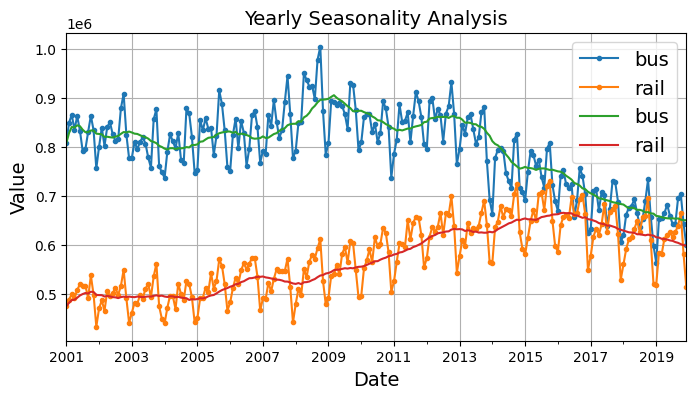

In [26]:
# Compute 12-month rolling average
rolling_average_12_months = df_monthly[period].rolling(window=12, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(8, 4))

df_monthly[period].plot(ax=ax, marker=".", label="Monthly Mean")
rolling_average_12_months.plot(ax=ax, grid=True, label="12-Month Rolling Average")

ax.set_title("Yearly Seasonality Analysis")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()

plt.show()

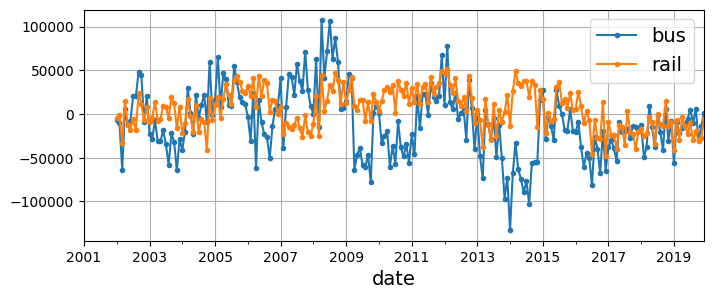

In [27]:
# 12 month difference

df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

# ARMA model

In [28]:
%pip install -q -U statsmodels

In [29]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [30]:
y_pred[0] # ARIMA

<ipython-input-30-31f10ff1ae3b>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0] # ARIMA


427758.6262875742

In [31]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [32]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data till "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))

    model = model.fit() # retrain the model every day
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

<ipython-input-32-36698edf2f73>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-32-36698edf2f73>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-32-36698edf2f73>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-32-36698edf2f73>:11: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [33]:
mae

32040.7201012105

# preparing data for ml models

In [34]:
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets= my_series[3:],
    sequence_length=3, # target are 3 step in future
    batch_size=2,
    shuffle=False
)

In [35]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [36]:
# window method

for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
  for i in window_dataset:
    print(f"{i}" ,end=" ")
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [37]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda i: i.batch(4))
for i in dataset:
    print(f"{i}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [38]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [39]:
# to split the input and target use the map() method

In [40]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [41]:
# train test valid

rail_train = df["rail"]["2016-01":"2018-12"]/1e6
rail_valid = df["rail"]["2019-01":"2019-05"]/1e6
rail_test = df["rail"]["2019-06"]/1e6

In [42]:
seq_length = 56
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# forecasting using a linear model

In [43]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, epochs=1000, validation_data=valid_ds, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0567 - mae: 0.2610 - val_loss: 0.0091 - val_mae: 0.0972
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - mae: 0.0983 - val_loss: 0.0066 - val_mae: 0.0838
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - mae: 0.0878 - val_loss: 0.0067 - val_mae: 0.0829
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - mae: 0.0850 - val_loss: 0.0061 - val_mae: 0.0793
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0820 - val_loss: 0.0057 - val_mae: 0.0763
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0784 - val_loss: 0.0066 - val_mae: 0.0842
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0795 - val_loss: 0.0053 - val_mae: 0.0722
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - mae: 0.0756 - val_loss: 0.0060 - val_mae: 0.0795
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l

In [44]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0390 


37825.752049684525

# forecasting using rnn

In [45]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,
                  metrics=["mae", "mse", tf.keras.metrics.MeanAbsolutePercentageError(name="mape")])

    # Train
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])

    # Evaluate
    valid_loss, valid_mae, valid_mse, valid_mape = model.evaluate(valid_set)
    return valid_mae * 1e6

In [47]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.4775 - mae: 0.8872 - mape: 147.9692 - mse: 1.0081 - val_loss: 0.0193 - val_mae: 0.1655 - val_mape: 39.1110 - val_mse: 0.0387
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0449 - mae: 0.2434 - mape: 56.0366 - mse: 0.0899 - val_loss: 0.0770 - val_mae: 0.3500 - val_mape: 80.6514 - val_mse: 0.1540
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0676 - mae: 0.3197 - mape: 70.2033 - mse: 0.1352 - val_loss: 0.0612 - val_mae: 0.3005 - val_mape: 71.4496 - val_mse: 0.1223
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0485 - mae: 0.2469 - mape: 58.4558 - mse: 0.0969 - val_loss: 0.0254 - val_mae: 0.1399 - val_mape: 41.0626 - val_mse: 0.0509
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0218 - mae: 0.1602 - mape: 38.3868 - mse: 0.0436 - val_loss: 0.0196 - val_mae: 0.1515 - val_mape: 38.7269 - val_mse: 0.0391
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202 - m

102805.17488718033

In [48]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function
])

In [49]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0261 - mae: 0.1662 - mape: 32.2739 - mse: 0.0523 - val_loss: 0.0032 - val_mae: 0.0577 - val_mape: 13.5178 - val_mse: 0.0065
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0048 - mae: 0.0687 - mape: 14.1480 - mse: 0.0096 - val_loss: 0.0023 - val_mae: 0.0472 - val_mape: 9.1793 - val_mse: 0.0046
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - mae: 0.0616 - mape: 12.8891 - mse: 0.0089 - val_loss: 0.0030 - val_mae: 0.0562 - val_mape: 11.9742 - val_mse: 0.0060
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - mae: 0.0600 - mape: 13.5037 - mse: 0.0093 - val_loss: 0.0026 - val_mae: 0.0492 - val_mape: 10.5782 - val_mse: 0.0052
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0533 - mape: 11.0505 - mse: 0.0069 - val_loss: 0.0033 - val_mae: 0.0603 - val_mape: 13.8606 - val_mse: 0.0066
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - ma

30447.00063765049

# Deep RNNs

In [50]:
tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(28, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(28, return_sequences=True),
    tf.keras.layers.SimpleRNN(28),
    tf.keras.layers.Dense(1)
])

In [51]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0466 - mae: 0.2064 - mape: 39.5597 - mse: 0.0936 - val_loss: 0.0059 - val_mae: 0.0833 - val_mape: 14.9983 - val_mse: 0.0118
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0070 - mae: 0.0911 - mape: 17.2685 - mse: 0.0139 - val_loss: 0.0028 - val_mae: 0.0559 - val_mape: 11.8694 - val_mse: 0.0056
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0062 - mae: 0.0826 - mape: 16.4374 - mse: 0.0124 - val_loss: 0.0027 - val_mae: 0.0533 - val_mape: 9.9549 - val_mse: 0.0054
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0053 - mae: 0.0720 - mape: 14.8157 - mse: 0.0106 - val_loss: 0.0024 - val_mae: 0.0502 - val_mape: 10.3069 - val_mse: 0.0049
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0049 - mae: 0.0668 - mape: 13.4781 - mse: 0.0098 - val_loss: 0.0030 - val_mae: 0.0555 - val_mape: 12.0165 - val_mse: 0.0059
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0059 - ma

29892.781749367714

# forecasting using multivariate time series

In [52]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar) # one hot encode day

In [53]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [54]:
tf.random.set_seed(42)
import numpy as np

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),  # Ensure float32 dtype
    targets=mulvar_train["rail"][seq_length:].to_numpy().astype(np.float32),  # Ensure float32 dtype
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),  # Ensure float32 dtype
    targets=mulvar_valid["rail"][seq_length:].to_numpy().astype(np.float32),  # Ensure float32 dtype
    sequence_length=seq_length,
    batch_size=32
)

In [55]:
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1548 - mae: 0.4168 - mape: 74.6089 - mse: 0.3332 - val_loss: 0.0182 - val_mae: 0.1854 - val_mape: 34.4047 - val_mse: 0.0363
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0080 - mae: 0.1000 - mape: 18.8730 - mse: 0.0160 - val_loss: 0.0028 - val_mae: 0.0662 - val_mape: 13.9101 - val_mse: 0.0056
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - mae: 0.0480 - mape: 9.3878 - mse: 0.0045 - val_loss: 0.0011 - val_mae: 0.0349 - val_mape: 7.6452 - val_mse: 0.0022
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.0381 - mape: 7.5265 - mse: 0.0029 - val_loss: 7.8126e-04 - val_mae: 0.0293 - val_mape: 6.1864 - val_mse: 0.0016
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - mae: 0.0376 - mape: 7.3976 - mse: 0.0029 - val_loss: 9.5051e-04 - val_mae: 0.0348 - val_mape: 7.2380 - val_mse: 0.0019
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 -

23793.015629053116

In [57]:
# A multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),  # Ensure float32 dtype
    targets=mulvar_train[["bus", "rail"]][seq_length:].to_numpy().astype(np.float32),  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),  # Ensure float32 dtype
    targets=mulvar_valid[["bus", "rail"]][seq_length:].to_numpy().astype(np.float32),
    sequence_length=seq_length,
    batch_size=32
)

In [58]:
tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds, learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0574 - mae: 0.2577 - mape: 42.9181 - mse: 0.1149 - val_loss: 0.0039 - val_mae: 0.0740 - val_mape: 12.6650 - val_mse: 0.0078
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035 - mae: 0.0602 - mape: 10.6951 - mse: 0.0070 - val_loss: 0.0013 - val_mae: 0.0393 - val_mape: 7.6382 - val_mse: 0.0026
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - mae: 0.0468 - mape: 8.2661 - mse: 0.0043 - val_loss: 0.0016 - val_mae: 0.0458 - val_mape: 8.9368 - val_mse: 0.0032
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - mae: 0.0445 - mape: 7.9641 - mse: 0.0042 - val_loss: 0.0012 - val_mae: 0.0375 - val_mape: 7.3154 - val_mse: 0.0024
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mae: 0.0439 - mape: 7.7931 - mse: 0.0040 - val_loss: 0.0016 - val_mae: 0.0472 - val_mape: 8.9944 - val_mse: 0.0033
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - mae: 0.0439 - mape: 

25804.93688583374

In [59]:
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [60]:
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_metric.update_state(mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    mae = 1e6 * mae_metric.result().numpy()
    print(name, int(mae))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
bus 26021
rail 25588


# Forecasting Several Steps Ahead

In [61]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


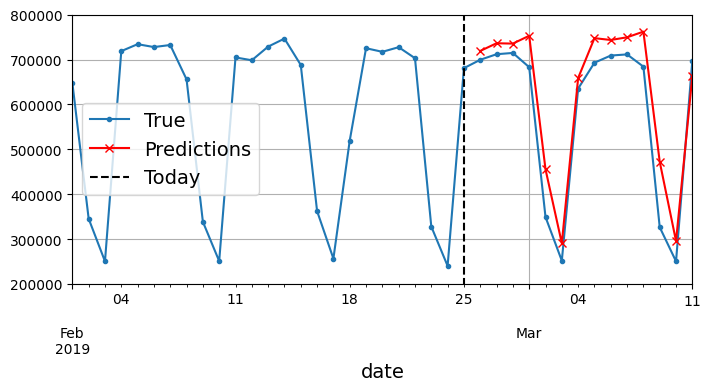

In [62]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))

(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])

plt.legend(loc="center left")
plt.show()

In [65]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Using a sequence to sequence model

In [68]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [69]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [70]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [80]:
seq2seq_train = to_seq2seq_dataset(mulvar_train.astype(np.float32), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid.astype(np.float32))

In [81]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 40ms/step - loss: 0.1532 - mae: 0.4199 - mape: 70.1992 - mse: 0.3186

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1509 - mae: 0.4157 - mape: 69.6025 - mse: 0.3138 - val_loss: 0.0173 - val_mae: 0.1457 - val_mape: 34.1910 - val_mse: 0.0345
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0130 - mae: 0.1239 - mape: 23.6869 - mse: 0.0260 - val_loss: 0.0088 - val_mae: 0.0961 - val_mape: 24.5914 - val_mse: 0.0175
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076 - mae: 0.0907 - mape: 17.4361 - mse: 0.0152 - val_loss: 0.0066 - val_mae: 0.0790 - val_mape: 20.3777 - val_mse: 0.0132
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 - mae: 0.0780 - mape: 14.9634 - mse: 0.0121 - val_loss: 0.0061 - val_mae: 0.0737 - val_mape: 19.5103 - val_mse: 0.0122
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052 - mae: 0.0694 - mape: 13.5231 - mse: 0.0104 - val_loss: 0.0054 - val_mae: 0.0677 - val_mape: 18.1279 - val_mse: 0.0109
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0048 - mae: 0.0653 -

46100.84742307663

In [84]:
X = mulvar_valid.to_numpy().astype(np.float32)[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


# Deep RNNs with Layer Norm

In [85]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [86]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [87]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.1871 - mae: 0.4601 - mape: 78.8831 - mse: 0.4165 - val_loss: 0.0218 - val_mae: 0.1456 - val_mape: 42.7012 - val_mse: 0.0435
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0150 - mae: 0.1428 - mape: 28.8209 - mse: 0.0300 - val_loss: 0.0150 - val_mae: 0.1248 - val_mape: 35.9519 - val_mse: 0.0300
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0117 - mae: 0.1248 - mape: 25.5516 - mse: 0.0235 - val_loss: 0.0129 - val_mae: 0.1157 - val_mape: 32.8090 - val_mse: 0.0259
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0104 - mae: 0.1149 - mape: 23.4317 - mse: 0.0207 - val_loss: 0.0115 - val_mae: 0.1084 - val_mape: 30.3423 - val_mse: 0.0229
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092 - mae: 0.1058 - mape: 21.2776 - mse: 0.0184 - val_loss: 0.0104 - val_mae: 0.1030 - val_mape: 28.5625 - val_mse: 0.0208
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - mae: 0.1072 - mape: 31.2

102989.90458250046

# LSTMs

In [88]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [89]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1284 - mae: 0.4228 - mape: 67.9228 - mse: 0.2569 - val_loss: 0.0191 - val_mae: 0.1597 - val_mape: 41.2829 - val_mse: 0.0381
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0176 - mae: 0.1661 - mape: 32.1042 - mse: 0.0352 - val_loss: 0.0177 - val_mae: 0.1461 - val_mape: 40.3882 - val_mse: 0.0354
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0156 - mae: 0.1537 - mape: 31.1304 - mse: 0.0312 - val_loss: 0.0168 - val_mae: 0.1431 - val_mape: 39.4656 - val_mse: 0.0336
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - mae: 0.1493 - mape: 30.2258 - mse: 0.0298 - val_loss: 0.0161 - val_mae: 0.1401 - val_mape: 38.6192 - val_mse: 0.0321
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0142 - mae: 0.1455 - mape: 29.5092 - mse: 0.0284 - val_loss: 0.0156 - val_mae: 0.1355 - val_mape: 37.9018 - val_mse: 0.0312
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - mae: 0.1378 - mape: 40.21

135463.28246593475

# GRUs

In [90]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [100]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0106 - mae: 0.1170 - mape: 23.3517 - mse: 0.0211 - val_loss: 0.0115 - val_mae: 0.1182 - val_mape: 31.3835 - val_mse: 0.0231
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0103 - mae: 0.1146 - mape: 22.8170 - mse: 0.0205 - val_loss: 0.0111 - val_mae: 0.1156 - val_mape: 30.6651 - val_mse: 0.0222
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0099 - mae: 0.1122 - mape: 22.3891 - mse: 0.0199 - val_loss: 0.0109 - val_mae: 0.1133 - val_mape: 30.2983 - val_mse: 0.0218
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096 - mae: 0.1094 - mape: 21.7598 - mse: 0.0192 - val_loss: 0.0105 - val_mae: 0.1109 - val_mape: 29.5353 - val_mse: 0.0210
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094 - mae: 0.1078 - mape: 21.5052 - mse: 0.0188 - val_loss: 0.0103 - val_mae: 0.1088 - val_mape: 29.1126 - val_mse: 0.0205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112 - mae: 0.1125 - mape: 31.57

108841.76939725876